In [1]:
from pathlib import Path
from fastai.vision.all import *

# Train the model using resnet

In [2]:
img_dir = Path('../data/processed/voronoi')

dls = ImageDataLoaders.from_folder(
    img_dir, 
    train='train',
    valid=None,
    valid_pct=0.2,
    bs=16,
    shuffle_train=True
)

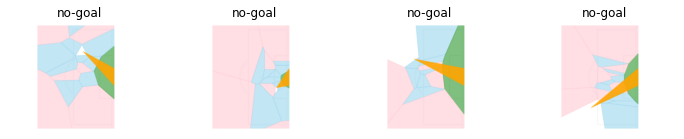

In [3]:
dls.show_batch(nrows=1, ncols=4)

In [4]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.43651583790779114)

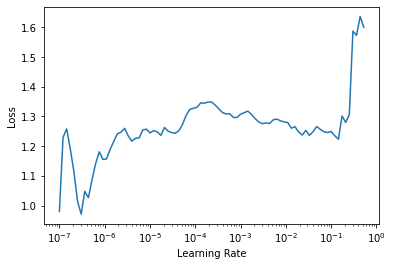

In [5]:
learn.lr_find()

In [6]:
learn.fit_one_cycle(3, slice(1e-7, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.927156,0.688887,0.169291,0.830709,00:06
1,0.550350,0.539617,0.129921,0.870079,00:06
2,0.332947,0.608640,0.149606,0.850394,00:07


In [7]:
learn.unfreeze()

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=7.585775847473997e-07)

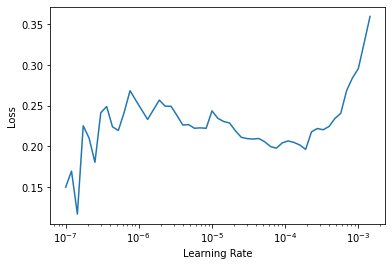

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.250980,0.584906,0.133858,0.866142,00:07
1,0.170724,0.620651,0.125984,0.874016,00:07
2,0.100471,0.595139,0.125984,0.874016,00:07


# Review the model

Make some predictions on the test-data.

First, let's go through predicting a single image...

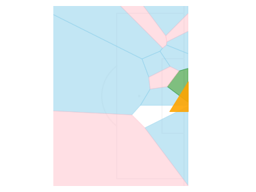

In [10]:
import PIL

# Load an image from the test data
example_img_path = (img_dir/'test'/'goal').ls()[0]
example_img = PILImage.create(example_img_path)

display(example_img.to_thumb(256, 256))

In [11]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

xG: 0.09853681921958923


Load all test data

In [12]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [13]:
import fastprogress
fastprogress.fastprogress.NO_BAR = True


def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = (img_dir/'test'/'goal').ls() + (img_dir/'test'/'no-goal').ls()
shots_predicted = [process_test_shot(s) for s in test_shots]

In [14]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

,path,id,is_goal,xg,sb_xg,diff
0,../data/processed/voronoi/test/goal/fcad2440-d5c8-4725-90f6-f5bcb54803ee.png,fcad2440-d5c8-4725-90f6-f5bcb54803ee,True,0.098537,0.501208,0.402672
1,../data/processed/voronoi/test/goal/9c0f10ad-bb11-414d-b1d3-7654d6f50b7c.png,9c0f10ad-bb11-414d-b1d3-7654d6f50b7c,True,0.996917,0.224554,0.772364
2,../data/processed/voronoi/test/goal/84ab1af4-93c7-479d-ad11-74cdb94813af.png,84ab1af4-93c7-479d-ad11-74cdb94813af,True,0.004252,0.520126,0.515874
3,../data/processed/voronoi/test/goal/6c021797-e716-4b36-b706-bef14ee69945.png,6c021797-e716-4b36-b706-bef14ee69945,True,0.004222,0.153766,0.149544
4,../data/processed/voronoi/test/goal/0ed1e0fe-2265-43c8-bbdf-f1f3318ed30e.png,0ed1e0fe-2265-43c8-bbdf-f1f3318ed30e,True,0.182310,0.310864,0.128554
...,...,...,...,...,...,...
347,../data/processed/voronoi/test/no-goal/cba70119-4cc3-4a36-bd50-0e11384ec1c5.png,cba70119-4cc3-4a36-bd50-0e11384ec1c5,False,0.008511,0.116078,0.107567
348,../data/processed/voronoi/test/no-goal/45d37fb5-6b8a-4e0b-b4aa-dc496032e87b.png,45d37fb5-6b8a-4e0b-b4aa-dc496032e87b,False,0.001616,0.032295,0.030679
349,../data/processed/voronoi/test/no-goal/953da3be-36e0-4c55-8263-17d955e588d3.png,953da3be-36e0-4c55-8263-17d955e588d3,False,0.186917,0.104702,0.082215
350,../data/processed/voronoi/test/no-goal/31c8bcbf-2115-4a4d-81ab-4d7b49a94ca1.png,31c8bcbf-2115-4a4d-81ab-4d7b49a94ca1,False,0.000299,0.029296,0.028997


Compare to SB xG

In [15]:
# Compare overall error rate between SB and image xG
import numpy as np


def mse(pred, obs):
    return np.mean((obs - pred)**2)


def rmse(pred, obs):
    return np.sqrt(mse(pred, obs))


print(rmse(predictions['is_goal'].mean(), predictions['is_goal']))
print(rmse(predictions['sb_xg'], predictions['is_goal']))
print(rmse(predictions['xg'], predictions['is_goal']))

0.2992409258688992
0.262085362225353
0.22600991868776904


ID: b30cf444-7718-4093-a163-cb13a2cde4a4
Im-xG: 1.00
SB-xG: 0.03
Goal: True
Diff:  0.97


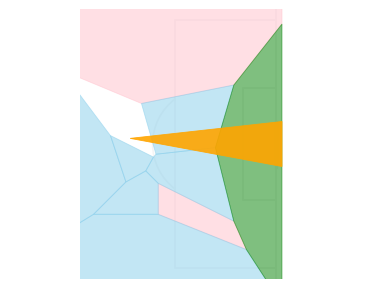

ID: ea8c6908-a26e-4983-b572-29429af7c71a
Im-xG: 1.00
SB-xG: 0.08
Goal: True
Diff:  0.92


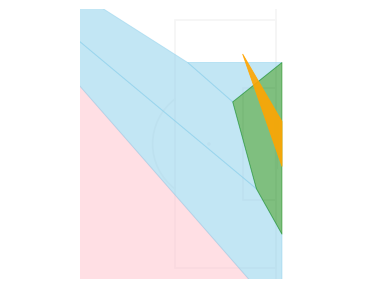

ID: 225889d8-8cd2-4268-89bc-0b07bf51ca86
Im-xG: 0.99
SB-xG: 0.08
Goal: True
Diff:  0.92


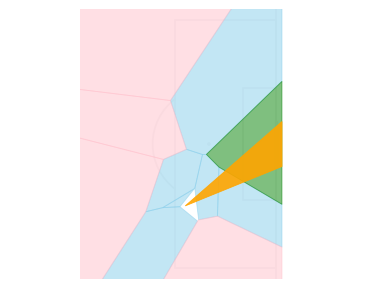

ID: d6ce4bc1-6922-47e0-becd-022645c02329
Im-xG: 0.98
SB-xG: 0.12
Goal: True
Diff:  0.86


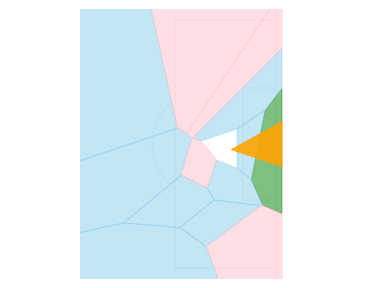

ID: 50733d67-5f40-4653-accb-32eef9e55740
Im-xG: 0.94
SB-xG: 0.09
Goal: True
Diff:  0.85


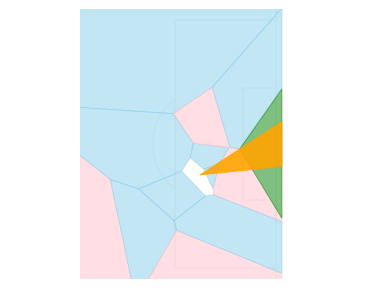

ID: fef0261f-ad2a-4175-aa3f-877d73b39b28
Im-xG: 0.86
SB-xG: 0.04
Goal: True
Diff:  0.82


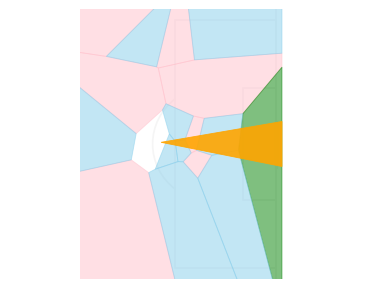

ID: d7eefde4-6f09-40bf-a322-a9fbfb6d4e5f
Im-xG: 0.99
SB-xG: 0.19
Goal: True
Diff:  0.81


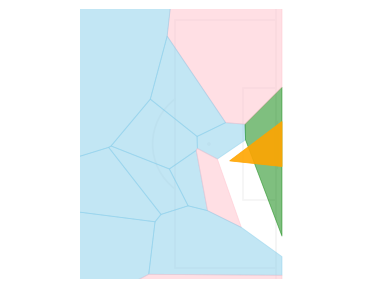

ID: 628e5642-f928-41d5-afc3-c66acf6c4e9f
Im-xG: 1.00
SB-xG: 0.20
Goal: True
Diff:  0.80


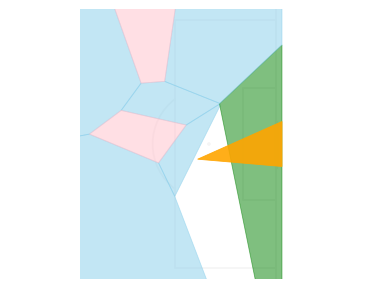

ID: c29b7bbf-015e-424a-ae81-9406d7842c71
Im-xG: 1.00
SB-xG: 0.21
Goal: True
Diff:  0.79


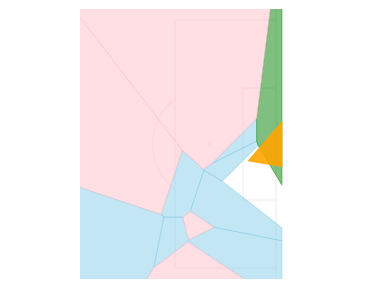

ID: a1055c84-0dcd-4f4d-bd7f-73ca751fab33
Im-xG: 0.87
SB-xG: 0.09
Goal: False
Diff:  0.78


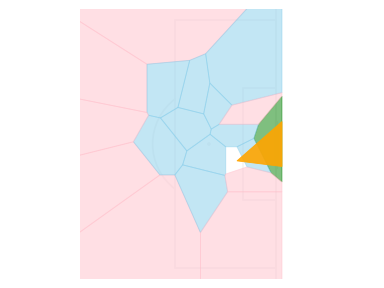

In [16]:
for _, p in predictions.sort_values(by='diff', ascending=False).head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

<AxesSubplot:xlabel='xg', ylabel='sb_xg'>

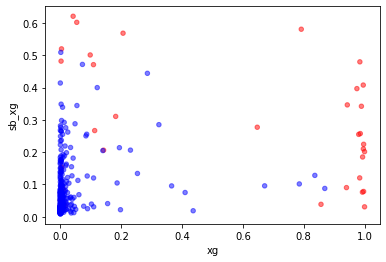

In [17]:
predictions.assign(is_goal=lambda df: df['is_goal'].map({False:'b', True:'r'})).plot(x='xg', y='sb_xg', c='is_goal', kind='scatter', alpha=0.5)

ID: a1055c84-0dcd-4f4d-bd7f-73ca751fab33
Im-xG: 0.87
SB-xG: 0.09
Goal: False
Diff:  0.78


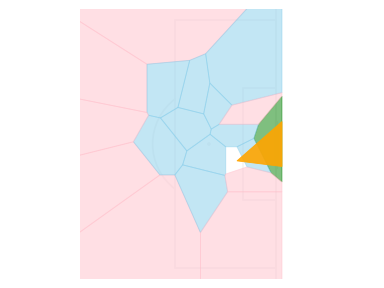

ID: f7ed14df-61ed-4f73-b616-42db3f983bf4
Im-xG: 0.84
SB-xG: 0.13
Goal: False
Diff:  0.71


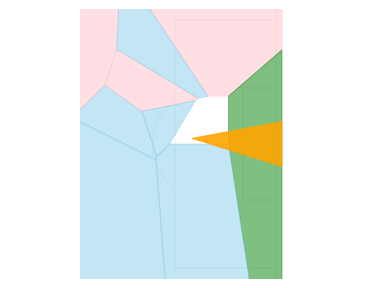

ID: 0eb25d3f-95b6-4fa4-a3cb-8d1bea753f7c
Im-xG: 0.79
SB-xG: 0.10
Goal: False
Diff:  0.68


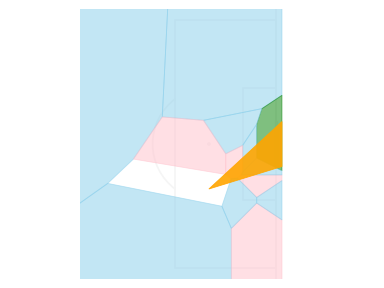

ID: 2d2852f7-06a4-487a-93ad-2d3092305a7a
Im-xG: 0.67
SB-xG: 0.10
Goal: False
Diff:  0.58


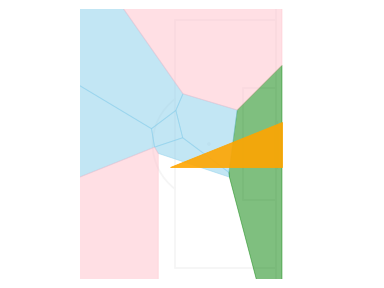

ID: 527a7a4c-577b-4575-97cf-caa90ce07087
Im-xG: 0.44
SB-xG: 0.02
Goal: False
Diff:  0.42


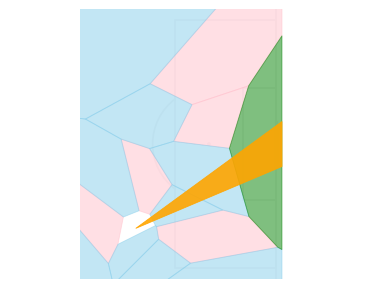

ID: 6123b959-1883-4c7c-82bc-877a2b1a83db
Im-xG: 0.41
SB-xG: 0.08
Goal: False
Diff:  0.34


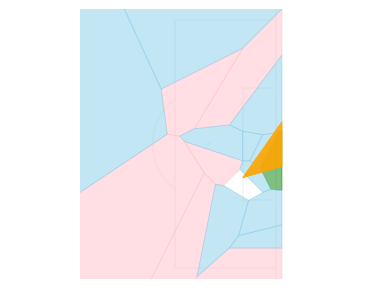

ID: b21b92a9-7904-4c57-8f48-6eed42804cbf
Im-xG: 0.37
SB-xG: 0.10
Goal: False
Diff:  0.27


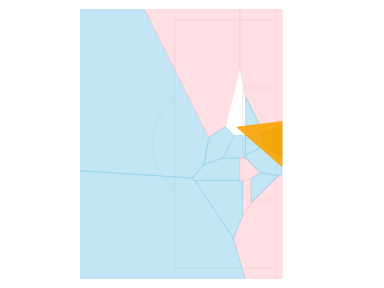

ID: 694908f4-d88e-4c07-9e90-7bd9f7521dc3
Im-xG: 0.32
SB-xG: 0.29
Goal: False
Diff:  0.04


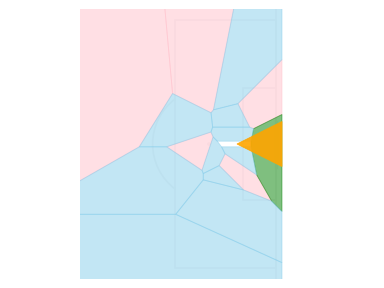

ID: b474599a-5a68-467d-b962-a36942c815bd
Im-xG: 0.29
SB-xG: 0.44
Goal: False
Diff:  0.16


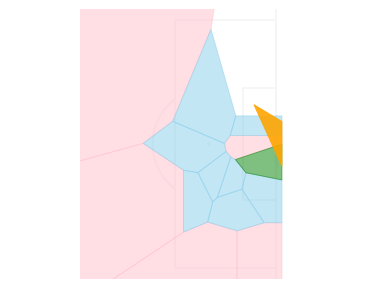

ID: b4c2012f-d39b-4b95-b550-e8781d74a1f8
Im-xG: 0.25
SB-xG: 0.13
Goal: False
Diff:  0.12


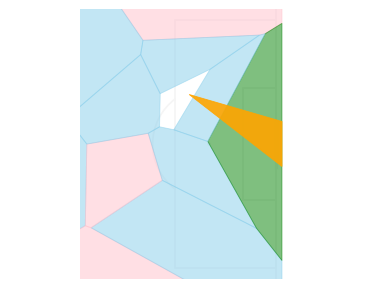

ID: 1502ce98-32d9-4839-a3fb-73611d3685d9
Im-xG: 0.23
SB-xG: 0.21
Goal: False
Diff:  0.02


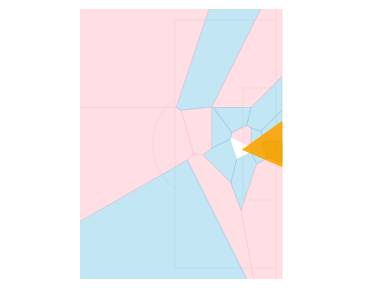

ID: 039861d2-6a1c-4030-8189-119a35a8caa0
Im-xG: 0.20
SB-xG: 0.02
Goal: False
Diff:  0.18


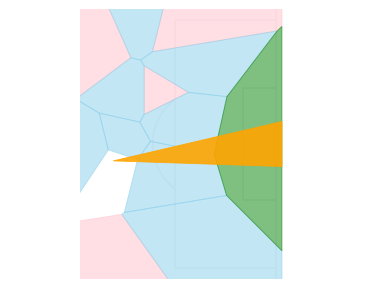

ID: b5014c8f-581b-417a-b9b5-f641c3334a66
Im-xG: 0.19
SB-xG: 0.21
Goal: False
Diff:  0.02


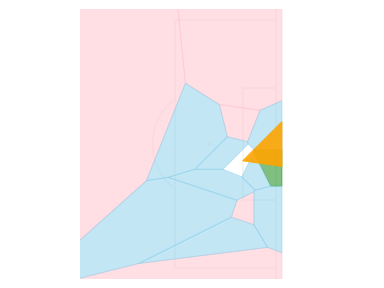

ID: 953da3be-36e0-4c55-8263-17d955e588d3
Im-xG: 0.19
SB-xG: 0.10
Goal: False
Diff:  0.08


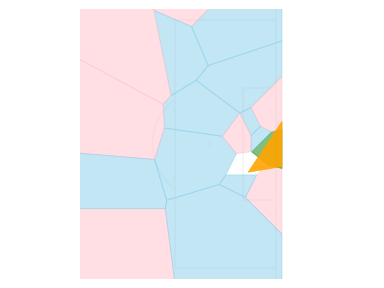

ID: 015c7c70-6761-4b25-a020-b60619a914d3
Im-xG: 0.16
SB-xG: 0.04
Goal: False
Diff:  0.12


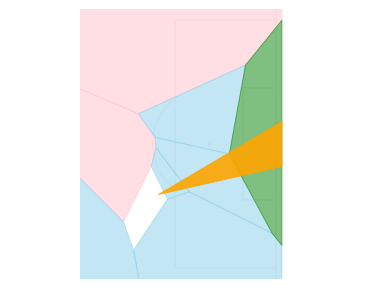

In [18]:
for _, p in predictions.loc[lambda df: ~df['is_goal']].sort_values(by='xg', ascending=False).head(15).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

<AxesSubplot:xlabel='xg', ylabel='is_goal'>

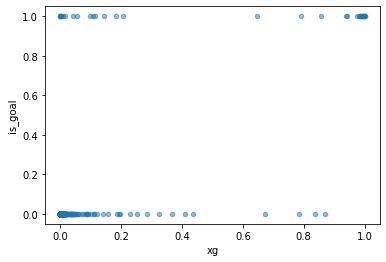

In [19]:
predictions.assign(is_goal=lambda df: df['is_goal'].astype(int)).plot(x='xg', y='is_goal', kind='scatter', alpha=0.5)